<a href="https://colab.research.google.com/github/intel-analytics/analytics-zoo/blob/master/docs/docs/colab-notebook/chronos/chronos_autots_nyc_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


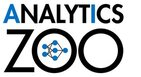
---

##### Copyright 2018 Analytics Zoo Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).


In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install Analytics Zoo**

You can install the latest pre-release version using `pip install --pre --upgrade analytics-zoo`. 

In [ ]:
# Install latest pre-release version of Analytics Zoo 
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo

In [ ]:
# Install required dependencies
!pip install ray[tune]==1.2.0 tensorflow==1.15.0

## **Step 0: Download & prepare dataset**
We used NYC taxi passengers dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot.

In [ ]:
# download the dataset
!wget https://raw.githubusercontent.com/numenta/NAB/v1.0/data/realKnownCause/nyc_taxi.csv

In [ ]:
# load the dataset. The downloaded dataframe contains two columns, "timestamp" and "value".
import pandas as pd
df = pd.read_csv("nyc_taxi.csv", parse_dates=["timestamp"])

## Data transformation and feature engineering using Chronos TSDataset 

In [2]:
from zoo.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

In [3]:
tsdata_train, tsdata_valid, tsdata_test = TSDataset.from_pandas(df, dt_col="timestamp", target_col="value",
                                                                with_split=True, val_ratio=0.1, test_ratio=0.1)

In [4]:
lookback = 6
horizon = 1
scaler = StandardScaler()

        #   .scale(scaler, fit=(tsdata is tsdata_train))\
for tsdata in [tsdata_train, tsdata_valid, tsdata_test]:
    tsdata.deduplicate()\
          .impute()\
          .gen_dt_feature()\
          .scale(scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=lookback, horizon=horizon)

## Time series forecasting using Chronos Forecaster

In [5]:
import torch
import numpy as np
import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [14]:
from zoo.chronos.model.forecast.tcn_forecaster import TCNForecaster

x, y = tsdata_train.to_numpy()
x_val, y_val = tsdata_valid.to_numpy()
forecaster = TCNForecaster(past_seq_len=lookback,
                            future_seq_len=horizon,
                            input_feature_num=x.shape[-1],
                            output_feature_num=y.shape[-1])
res = forecaster.fit(x, y, validation_data=(x_val, y_val), epochs=3)

Loss: 0.07632646709680557: 100%|██████████| 258/258 [00:09<00:00, 25.91it/s]


In [15]:
x_test, y_test = tsdata_test.to_numpy()
pred = forecaster.predict(x_test)

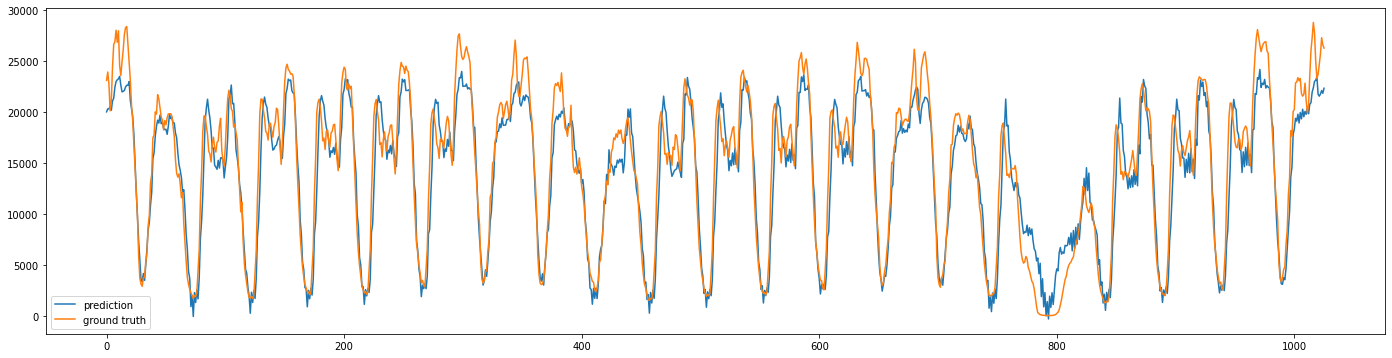

In [16]:
import matplotlib.pyplot as plt
pred_unscale, groundtruth_unscale = tsdata_test._unscale_numpy(pred), tsdata_test._unscale_numpy(y_test)
plt.figure(figsize=(24,6))
plt.plot(pred_unscale[:,:,0])
plt.plot(groundtruth_unscale[:,:,0])
plt.legend(["prediction", "ground truth"])

## **Distributed automl for time series forecasting using Chronos AutoTS**

In this guide we will demonstrate how to use Chronos AutoTS for automated time seires forecasting in 4 simple steps.

In [ ]:
# split the dataframe into train/validation/test set.
from zoo.chronos.preprocessing.utils import train_val_test_split
train_df, val_df, test_df = train_val_test_split(df, val_ratio=0.1, test_ratio=0.1)

### **Step 1: Init Orca Context** 

In [ ]:
# import necesary libraries and modules
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook). 
init_orca_context(cluster_mode="local", cores=4) # run in local mode

### **Step 2: Create an AutoTSTrainer**


In [ ]:
from zoo.chronos.autots.forecast import AutoTSTrainer

trainer = AutoTSTrainer(dt_col="timestamp",  # the column name specifying datetime
                        target_col="value",  # the column name to predict
                        horizon=1,           # number of steps to look forward
                        extra_features_col=None # a list of column names which are also included in input as features except dt_col and target_col.
                        )

### **Step 3: Fit with AutoTSTrainer**

Use a recipe to specify desired search space. `AutoTSTrainer` returns a result `TSPipeline` for easy deployment after fit.

In [ ]:
from zoo.chronos.config.recipe import LSTMGridRandomRecipe
ts_pipeline = trainer.fit(train_df, val_df, 
                          recipe=LSTMGridRandomRecipe(
                              num_rand_samples=1,
                              epochs=1,
                              look_back=6, 
                              batch_size=[64]),
                          metric="mse")

### **Step 4: Further deployment with TSPipeline**

In [ ]:
# predict with the best trial
pred_df = ts_pipeline.predict(test_df)

In [ ]:
# evaluate the result pipeline
mse, smape = ts_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

In [ ]:
# save the pipeline
my_ppl_file_path = ts_pipeline.save("/tmp/saved_pipeline/nyc_taxi.ppl")

In [ ]:
# restore the pipeline for further deployment
from zoo.chronos.autots.forecast import TSPipeline
loaded_ppl = TSPipeline.load(my_ppl_file_path)

In [ ]:
# Stop orca context when your program finishes
stop_orca_context()